# Local MLflow SQLite Exploration
Use this notebook to point at a transferred `mlflow.db`, extract runs, apply filters, and inspect metrics.

In [14]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Iterable, Mapping, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow
from mlflow.entities import Run
from mlflow.tracking import MlflowClient

DB_CANDIDATES: Sequence[Path] = (
    Path("../results/mlflow.db"),
    Path("../mlruns/mlflow.db"),
    Path("../mlflow.db"),
    Path("mlflow.db"),
 )

@dataclass
class RunFilters:
    experiment_names: Iterable[str] | None = None
    status: Iterable[str] | None = None
    start_after: datetime | None = None
    start_before: datetime | None = None
    tags: Mapping[str, str] | None = None
    params: Mapping[str, str] | None = None
    supervision_mode: str | None = None
    tag_supervision_mode: str | None = None
    parent_only: bool = False
    child_only: bool = False

def resolve_db_path(candidates: Sequence[Path]) -> Path:
    """Return the first existing SQLite path from the provided candidates."""
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        "No MLflow SQLite database found. Update DB_CANDIDATES with the correct path."
    )

MLFLOW_DB_PATH = resolve_db_path(DB_CANDIDATES)
BACKEND_STORE_URI = f"sqlite:///{MLFLOW_DB_PATH}"
mlflow.set_tracking_uri(BACKEND_STORE_URI)
CLIENT = MlflowClient(tracking_uri=BACKEND_STORE_URI)
MLFLOW_DB_PATH

2025/12/02 07:13:59 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/02 07:14:00 INFO mlflow.store.db.utils: Updating database tables
2025-12-02 07:14:00 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-02 07:14:00 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-12-02 07:14:00 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-12-02 07:14:00 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


PosixPath('/home/ladmin/Documents/tsseg/tsseg-exp/results/mlflow.db')

In [15]:
def _experiment_ids_from_names(names: Iterable[str] | None) -> list[str]:
    if not names:
        return [exp.experiment_id for exp in CLIENT.search_experiments()]
    experiments = {exp.name: exp.experiment_id for exp in CLIENT.search_experiments()}
    missing = [name for name in names if name not in experiments]
    if missing:
        raise KeyError(
            f"Experiments not found in backend: {missing}. Available: {sorted(experiments)}"
        )
    return [experiments[name] for name in names]

def _build_filter_string(filters: RunFilters) -> str:
    clauses: list[str] = []
    # MLflow filter syntax does not support NULL comparisons on tags, so parent/child
    # filtering is performed after the search query completes.
    if filters.status:
        statuses = list(filters.status)
        if len(statuses) == 1:
            clauses.append(f"attributes.status = '{statuses[0].upper()}'")
        else:
            status_clause = " or ".join(
                f"attributes.status = '{status.upper()}'" for status in statuses
            )
            clauses.append(f"({status_clause})")
    if filters.start_after:
        millis = int(filters.start_after.timestamp() * 1000)
        clauses.append(f"attributes.start_time >= {millis}")
    if filters.start_before:
        millis = int(filters.start_before.timestamp() * 1000)
        clauses.append(f"attributes.start_time <= {millis}")
    if filters.tags:
        for key, value in filters.tags.items():
            clauses.append(f"tags.{key} = '{value}'")
    if filters.params:
        for key, value in filters.params.items():
            clauses.append(f"params.{key} = '{value}'")
    # Convenience: allow explicit supervision_mode on RunFilters (maps to param supervision_mode)
    if getattr(filters, "supervision_mode", None):
        clauses.append(f"params.supervision_mode = '{filters.supervision_mode}'")
    # Convenience: allow explicit tag_supervision_mode on RunFilters (maps to tag supervision_mode)
    if getattr(filters, "tag_supervision_mode", None):
        clauses.append(f"tags.supervision_mode = '{filters.tag_supervision_mode}'")
    return " and ".join(clauses)

def search_runs(filters: RunFilters | None = None, max_results: int = 50000) -> list[Run]:
    filters = filters or RunFilters()
    if filters.parent_only and filters.child_only:
        raise ValueError("Cannot request both parent and child runs simultaneously.")
    experiment_ids = _experiment_ids_from_names(filters.experiment_names)
    filter_string = _build_filter_string(filters)
    paged_runs = CLIENT.search_runs(
        experiment_ids=experiment_ids,
        filter_string=filter_string,
        run_view_type=mlflow.entities.ViewType.ALL,
        max_results=max_results,
        order_by=["attributes.start_time DESC"],
    )
    runs = list(paged_runs)
    if filters.parent_only:
        runs = [run for run in runs if not run.data.tags.get("mlflow.parentRunId")] 
    if filters.child_only:
        runs = [run for run in runs if run.data.tags.get("mlflow.parentRunId")] 
    return runs

In [16]:
def runs_to_frame(runs: Sequence[Run]) -> pd.DataFrame:
    if not runs:
        return pd.DataFrame()
    records: list[dict] = []
    for run in runs:
        info = run.info
        data = run.data
        row: dict[str, object] = {
            "run_id": info.run_id,
            "experiment_id": info.experiment_id,
            "name": data.tags.get("mlflow.runName", info.run_id),
            "status": info.status,
            "start_time": pd.to_datetime(info.start_time, unit="ms"),
            "end_time": (
                pd.to_datetime(info.end_time, unit="ms") if info.end_time else pd.NaT
            ),
            "lifecycle_stage": info.lifecycle_stage,
            "artifact_uri": info.artifact_uri,
            "parent_run_id": data.tags.get("mlflow.parentRunId"),
            "dataset_name": data.tags.get("dataset_name"),
            "algorithm_name": data.params.get("algorithm_name") or data.tags.get("algorithm_name"),
            "pipeline": data.params.get("pipeline") or data.tags.get("pipeline"),
            "supervision_mode": data.params.get("supervision_mode"),
        }
        row.update({f"param_{key}": value for key, value in data.params.items()})
        row.update({f"metric_{key}": value for key, value in data.metrics.items()})
        row.update({f"tag_{key}": value for key, value in data.tags.items()})
        records.append(row)
    df = pd.DataFrame.from_records(records)
    if not df.empty:
        df.sort_values("start_time", ascending=False, inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [17]:
def filter_metric_table(df: pd.DataFrame, metric_key: str) -> pd.DataFrame:
    column = f"metric_{metric_key}"
    if column not in df.columns:
        raise KeyError(
            f"Metric '{metric_key}' not present. Available metrics: {sorted(c[7:] for c in df.columns if c.startswith('metric_'))}"
        )
    subset = df[["run_id", "name", "status", column, "start_time", "dataset_name", "tag_algorithm_task", "supervision_mode"]].copy()
    subset.rename(columns={column: metric_key}, inplace=True)
    return subset

def list_run_artifacts(run_id: str, path: str | None = None) -> pd.DataFrame:
    artifacts = CLIENT.list_artifacts(run_id, path or "")
    rows = []
    for item in artifacts:
        rows.append(
            {
                "path": item.path,
                "is_dir": item.is_dir,
                "file_size": getattr(item, "file_size", None),
            }
        )
    return pd.DataFrame(rows)

In [19]:
example_filters = RunFilters(
    experiment_names=["tsseg-experiment"],
    status=["FINISHED"],
    start_after=datetime(2025, 11, 23),
    child_only=True,
    supervision_mode="unsupervised",
    tag_supervision_mode="unsupervised"
)

runs = search_runs(example_filters)
runs_df = runs_to_frame(runs)
runs_df.head()

,run_id,experiment_id,name,status,start_time,end_time,lifecycle_stage,artifact_uri,parent_run_id,dataset_name,...,tag_dataset_trial_index,tag_algorithm_task,tag_status,tag_supervision_mode,tag_algorithm_semi_supervised,metric_adjusted_rand_index_score,metric_weighted_adjusted_rand_index_score,metric_state_matching_score_score,metric_adjusted_mutual_info_score,metric_normalized_mutual_info_score
0,4df56f0167c642579c416c870a7bca95,1,tscp2_has_unsupervised_36,FINISHED,2025-11-25 11:20:46.786,2025-11-25 12:00:54.847,active,/scratch/fchavell/tsseg-exp/mlartifacts/1/4df5...,cf782dde50d349c6b52a856c965b12bd,has,...,36,change_point,completed,unsupervised,False,NaN,NaN,NaN,NaN,NaN
1,923e84d8f6514152aff3bbff8dcb165b,1,tscp2_usc-had_unsupervised_7,FINISHED,2025-11-25 10:30:51.218,2025-11-25 12:52:27.186,active,/scratch/fchavell/tsseg-exp/mlartifacts/1/923e...,c4dc9fac55ce4feea091aa49317e3e90,usc-had,...,7,change_point,completed,unsupervised,False,NaN,NaN,NaN,NaN,NaN
2,b6a743a4c074460bab8019512de6e7d1,1,tscp2_has_unsupervised_35,FINISHED,2025-11-25 10:14:15.631,2025-11-25 11:20:46.718,active,/scratch/fchavell/tsseg-exp/mlartifacts/1/b6a7...,cf782dde50d349c6b52a856c965b12bd,has,...,35,change_point,completed,unsupervised,False,NaN,NaN,NaN,NaN,NaN
3,31e703cf1090458ea68b19ccd71ef7d1,1,tscp2_has_unsupervised_34,FINISHED,2025-11-25 09:05:54.805,2025-11-25 10:14:13.956,active,/scratch/fchavell/tsseg-exp/mlartifacts/1/31e7...,cf782dde50d349c6b52a856c965b12bd,has,...,34,change_point,completed,unsupervised,False,NaN,NaN,NaN,NaN,NaN
4,00faad93886141c89414d378559bc13d,1,tscp2_usc-had_unsupervised_6,FINISHED,2025-11-25 07:55:55.600,2025-11-25 10:30:51.147,active,/scratch/fchavell/tsseg-exp/mlartifacts/1/00fa...,c4dc9fac55ce4feea091aa49317e3e90,usc-had,...,6,change_point,completed,unsupervised,False,NaN,NaN,NaN,NaN,NaN


In [6]:
earliest_run = runs_df.loc[[runs_df["start_time"].idxmin()]]
earliest_run

,run_id,experiment_id,name,status,start_time,end_time,lifecycle_stage,artifact_uri,parent_run_id,dataset_name,...,metric_weighted_adjusted_rand_index_score,metric_state_matching_score_score,metric_adjusted_mutual_info_score,metric_normalized_mutual_info_score,param_trial_supervision_override_n_segments,param_trial_supervision_override_n_max_states,param_trial_supervision_override_alphabet_size,param_trial_supervision_override_n_changepoints,param_trial_supervision_override_k_max,param_trial_supervision_override_n_change_points
23062,05200496c8b249f0bb5ed2dabafb9867,1,time2state_mocap_unsupervised_1,FINISHED,2025-11-24 01:43:35.362,2025-11-24 01:44:33.837,active,/scratch/fchavell/tsseg-exp/mlartifacts/1/0520...,a60377e4979a4679bb7d4344c6ab57bd,mocap,...,0.975141,0.940681,0.854552,0.854736,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
covering_table = filter_metric_table(runs_df, "covering_score")
covering_table.head()

,run_id,name,status,covering_score,start_time,dataset_name,tag_algorithm_task
0,827dd8c0385d4d4c90da8f4f6e858ed4,tscp2_has_semi_supervised_34,FINISHED,0.367776,2025-11-25 09:14:34.088,has,change_point
1,31e703cf1090458ea68b19ccd71ef7d1,tscp2_has_unsupervised_34,FINISHED,0.716689,2025-11-25 09:05:54.805,has,change_point
2,a3f2f0cc8b3949728ab182aa7f47f44a,tscp2_utsa_semi_supervised_20,FINISHED,0.765041,2025-11-25 08:21:39.328,utsa,change_point
3,00faad93886141c89414d378559bc13d,tscp2_usc-had_unsupervised_6,FINISHED,0.393754,2025-11-25 07:55:55.600,usc-had,change_point
4,9aba909604cb4b3b80e0eef66d2e266f,tscp2_utsa_unsupervised_32,FINISHED,0.466453,2025-11-25 07:47:06.049,utsa,change_point


## Run Statistics Summary
The following cells derive aggregated counts and basic statistics grouped by dataset and run type.

In [8]:
if runs_df.empty:
    print("No runs available for the requested filters.")
else:
    stats_df = runs_df.copy()
    stats_df["dataset_name"] = stats_df["dataset_name"].fillna("unknown")
    stats_df["algorithm_name"] = stats_df["algorithm_name"].fillna("unknown")
    if "pipeline" not in stats_df.columns:
        stats_df["pipeline"] = "unknown"
    else:
        stats_df["pipeline"] = stats_df["pipeline"].fillna("unknown")
    if "tag_status" not in stats_df.columns:
        stats_df["tag_status"] = np.nan
    stats_df["derived_status"] = stats_df["tag_status"].fillna(stats_df["status"])
    stats_df["is_child_run"] = stats_df["parent_run_id"].notna()
    stats_df["is_parent_run"] = ~stats_df["is_child_run"]
    stats_df["run_type"] = np.where(stats_df["is_parent_run"], "parent", "child")
    missing_dataset = int((stats_df["dataset_name"] == "unknown").sum())
    missing_algorithm = int((stats_df["algorithm_name"] == "unknown").sum())
    overview = pd.Series(
        {
            "total_runs": int(len(stats_df)),
            "parent_runs": int(stats_df["is_parent_run"].sum()),
            "child_runs": int(stats_df["is_child_run"].sum()),
            "unique_datasets": int(stats_df["dataset_name"].nunique()),
            "unique_algorithms": int(stats_df["algorithm_name"].nunique()),
            "runs_missing_dataset": missing_dataset,
            "runs_missing_algorithm": missing_algorithm,
        }
    )
    display(overview.to_frame(name="value"))
    mlflow_status_counts = stats_df["status"].value_counts(dropna=False).rename_axis("mlflow_status").reset_index(name="run_count")
    tag_status_counts = stats_df["derived_status"].value_counts(dropna=False).rename_axis("derived_status").reset_index(name="run_count")
    display(mlflow_status_counts.sort_values("run_count", ascending=False).reset_index(drop=True))
    display(tag_status_counts.sort_values("run_count", ascending=False).reset_index(drop=True))

,value
total_runs,23063
parent_runs,0
child_runs,23063
unique_datasets,7
unique_algorithms,29
runs_missing_dataset,0
runs_missing_algorithm,0


,mlflow_status,run_count
0,FINISHED,23063


,derived_status,run_count
0,completed,23063


In [9]:
if runs_df.empty:
    dataset_summary = pd.DataFrame()
else:
    def _summarise_group(group: pd.DataFrame) -> pd.Series:
        total = len(group)
        parent_runs = int(group["is_parent_run"].sum())
        child_runs = int(group["is_child_run"].sum())
        mlflow_status = group["status"].fillna("UNKNOWN")
        tag_status = group["derived_status"].fillna("").str.lower()
        exec_times = group.get("metric_execution_time_seconds")
        summary = {
            "total_runs": total,
            "parent_runs": parent_runs,
            "child_runs": child_runs,
            "mlflow_finished_runs": int((mlflow_status == "FINISHED").sum()),
            "mlflow_failed_runs": int((mlflow_status == "FAILED").sum()),
            "mlflow_running_runs": int((mlflow_status == "RUNNING").sum()),
            "mlflow_killed_runs": int((mlflow_status == "KILLED").sum()),
            "tag_completed_runs": int((tag_status == "completed").sum()),
            "tag_timeout_runs": int((tag_status == "timeout").sum()),
            "tag_failed_runs": int((tag_status == "failed").sum()),
            "tag_running_runs": int((tag_status == "running").sum()),
            "child_per_parent": float(child_runs / parent_runs) if parent_runs else np.nan,
            "avg_exec_time_s": float(exec_times.mean()) if exec_times is not None and exec_times.notna().any() else np.nan,
            "median_exec_time_s": float(exec_times.median()) if exec_times is not None and exec_times.notna().any() else np.nan,
        }
        return pd.Series(summary)
    dataset_summary = (
        stats_df.groupby("dataset_name", dropna=False)
        .apply(_summarise_group)
        .reset_index()
        .sort_values("total_runs", ascending=False)
    )
dataset_summary

/tmp/ipykernel_7651/1391810524.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


,dataset_name,total_runs,parent_runs,child_runs,mlflow_finished_runs,mlflow_failed_runs,mlflow_running_runs,mlflow_killed_runs,tag_completed_runs,tag_timeout_runs,tag_failed_runs,tag_running_runs,child_per_parent,avg_exec_time_s,median_exec_time_s
1,has,11832.0,0.0,11832.0,11832.0,0.0,0.0,0.0,11832.0,0.0,0.0,0.0,NaN,120.485666,9.677321
4,tssb,3614.0,0.0,3614.0,3614.0,0.0,0.0,0.0,3614.0,0.0,0.0,0.0,NaN,63.196519,3.718696
5,usc-had,3196.0,0.0,3196.0,3196.0,0.0,0.0,0.0,3196.0,0.0,0.0,0.0,NaN,464.359602,62.248746
3,skab,2040.0,0.0,2040.0,2040.0,0.0,0.0,0.0,2040.0,0.0,0.0,0.0,NaN,34.864262,3.209988
6,utsa,1711.0,0.0,1711.0,1711.0,0.0,0.0,0.0,1711.0,0.0,0.0,0.0,NaN,306.955421,10.164835
2,mocap,558.0,0.0,558.0,558.0,0.0,0.0,0.0,558.0,0.0,0.0,0.0,NaN,341.235829,22.168602
0,actrectut,112.0,0.0,112.0,112.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,NaN,1822.080181,87.901598


In [10]:
if runs_df.empty:
    status_by_dataset = pd.DataFrame()
else:
    status_by_dataset = (
        stats_df.assign(derived_status_lower=stats_df["derived_status"].fillna("").str.lower())
        .pivot_table(
            index="dataset_name",
            columns="derived_status_lower",
            values="run_id",
            aggfunc="count",
            fill_value=0
        )
        .sort_index()
    )
status_by_dataset

derived_status_lower,completed
dataset_name,
actrectut,112
has,11832
mocap,558
skab,2040
tssb,3614
usc-had,3196
utsa,1711


In [11]:
if runs_df.empty:
    pipeline_summary = pd.DataFrame()
else:
    pipeline_summary = (
        stats_df.groupby(["pipeline", "run_type"], dropna=False)
        .apply(
            lambda group: pd.Series(
                {
                    "total_runs": len(group),
                    "mlflow_finished_runs": int((group["status"] == "FINISHED").sum()),
                    "mlflow_failed_runs": int((group["status"] == "FAILED").sum()),
                    "tag_completed_runs": int((group["derived_status"].str.lower() == "completed").sum()),
                    "tag_timeout_runs": int((group["derived_status"].str.lower() == "timeout").sum()),
                }
            )
        )
        .reset_index()
        .sort_values(["pipeline", "run_type"])
    )
pipeline_summary

/tmp/ipykernel_7651/4130786430.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,pipeline,run_type,total_runs,mlflow_finished_runs,mlflow_failed_runs,tag_completed_runs,tag_timeout_runs
0,unknown,child,23063,23063,0,23063,0


In [12]:
if runs_df.empty:
    parent_child_summary = pd.DataFrame()
else:
    parent_runs_df = stats_df[stats_df["is_parent_run"]][[
        "run_id",
        "name",
        "status",
        "derived_status",
        "dataset_name",
        "algorithm_name",
        "metric_execution_time_seconds",
    ]].rename(columns={
        "execution_time_seconds": "parent_exec_time_s",
        "status": "mlflow_status",
        "derived_status": "tag_status",
    })
    child_stats = stats_df[stats_df["is_child_run"]].copy()
    child_stats["derived_status_lower"] = child_stats["derived_status"].fillna("").str.lower()
    child_group = (
        child_stats.groupby("parent_run_id")
        .agg(
            child_runs=("run_id", "count"),
            finished_children=("status", lambda s: int((s == "FINISHED").sum())),
            failed_children=("status", lambda s: int((s == "FAILED").sum())),
            running_children=("status", lambda s: int((s == "RUNNING").sum())),
            tag_completed_children=("derived_status_lower", lambda s: int((s == "completed").sum())),
            tag_failed_children=("derived_status_lower", lambda s: int((s == "failed").sum())),
            tag_timeout_children=("derived_status_lower", lambda s: int((s == "timeout").sum())),
        )
    )
    parent_child_summary = parent_runs_df.merge(
        child_group, left_on="run_id", right_index=True, how="left"
    ).fillna(0)
    numeric_cols = [
        "child_runs",
        "finished_children",
        "failed_children",
        "running_children",
        "tag_completed_children",
        "tag_failed_children",
        "tag_timeout_children",
    ]
    parent_child_summary[numeric_cols] = parent_child_summary[numeric_cols].astype(int)
parent_child_summary.head(20)

,run_id,name,mlflow_status,tag_status,dataset_name,algorithm_name,metric_execution_time_seconds,child_runs,finished_children,failed_children,running_children,tag_completed_children,tag_failed_children,tag_timeout_children


## Visualizations
Use the helpers below to generate plots from the consolidated statistics once they have been inspected.

In [12]:
def plot_metric_boxplot(
    df: pd.DataFrame,
    metric_key: str,
    algo_column: str = "name",
    dataset_column: str = "dataset_name",
    title: str | None = None,
) -> None:
    """Plot a metric distribution grouped by algorithm with dataset hue."""
    if df.empty:
        raise ValueError("No runs available to plot.")
    metric_col = f"metric_{metric_key}" if f"metric_{metric_key}" in df.columns else metric_key
    if metric_col not in df.columns:
        available = sorted(c[7:] for c in df.columns if c.startswith("metric_"))
        raise KeyError(f"Column '{metric_col}' not found. Available metric columns: {available}")
    plot_df = df[[algo_column, dataset_column, metric_col]].copy() if dataset_column in df.columns else df[[algo_column, metric_col]].copy()
    plot_df.rename(columns={algo_column: "algorithm", metric_col: metric_key}, inplace=True)
    if dataset_column in df.columns:
        plot_df.rename(columns={dataset_column: "dataset"}, inplace=True)
        plot_df["dataset"].fillna("Unknown dataset", inplace=True)
    else:
        plot_df["dataset"] = "Unknown dataset"
    plot_df.dropna(subset=[metric_key], inplace=True)
    if plot_df.empty:
        raise ValueError(f"No data available for metric '{metric_key}' after dropping NaNs.")
    plot_df["algorithm"] = plot_df["algorithm"].apply(lambda x: x.split("_")[0] if isinstance(x, str) and "_" in x else x).fillna("Unknown")
    order = plot_df.groupby("algorithm")[metric_key].median().sort_values(ascending=False).index.tolist()
    hue_order = sorted(plot_df["dataset"].unique())
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=plot_df, x="algorithm", y=metric_key, order=order, color="white", fliersize=0)
    sns.stripplot(
        data=plot_df,
        x="algorithm",
        y=metric_key,
        hue="dataset",
        order=order,
        hue_order=hue_order,
        dodge=False,
        marker="o",
        size=5,
        alpha=0.7,
    )
    plt.title(title or f"{metric_key} distribution by algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel(metric_key)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7917/149688578.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)


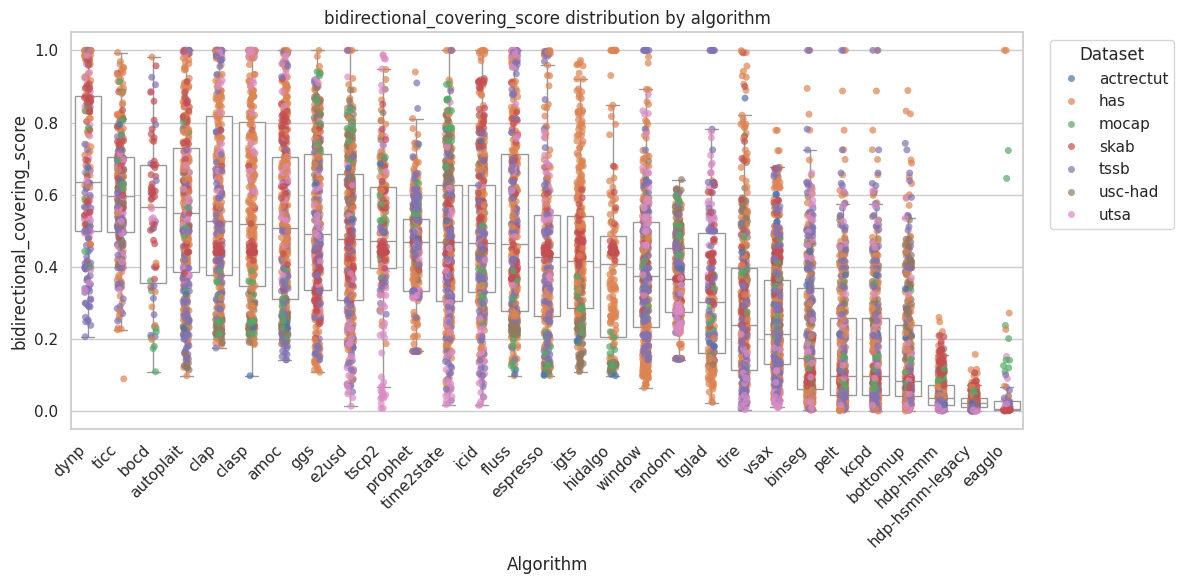

In [20]:
if runs_df.empty:
    print("No runs available to plot.")
else:
    plot_metric_boxplot(runs_df, metric_key="bidirectional_covering_score")

/tmp/ipykernel_7651/149688578.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)


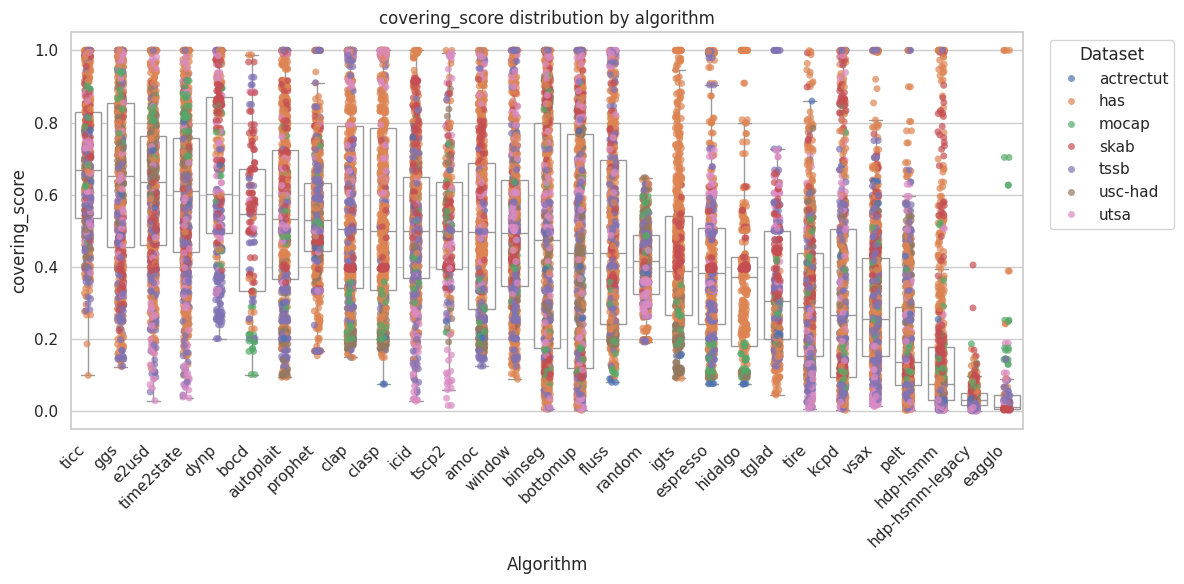

In [15]:
if runs_df.empty:
    print("No runs available to plot.")
else:
    plot_metric_boxplot(runs_df, metric_key="covering_score")

/tmp/ipykernel_22744/149688578.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)


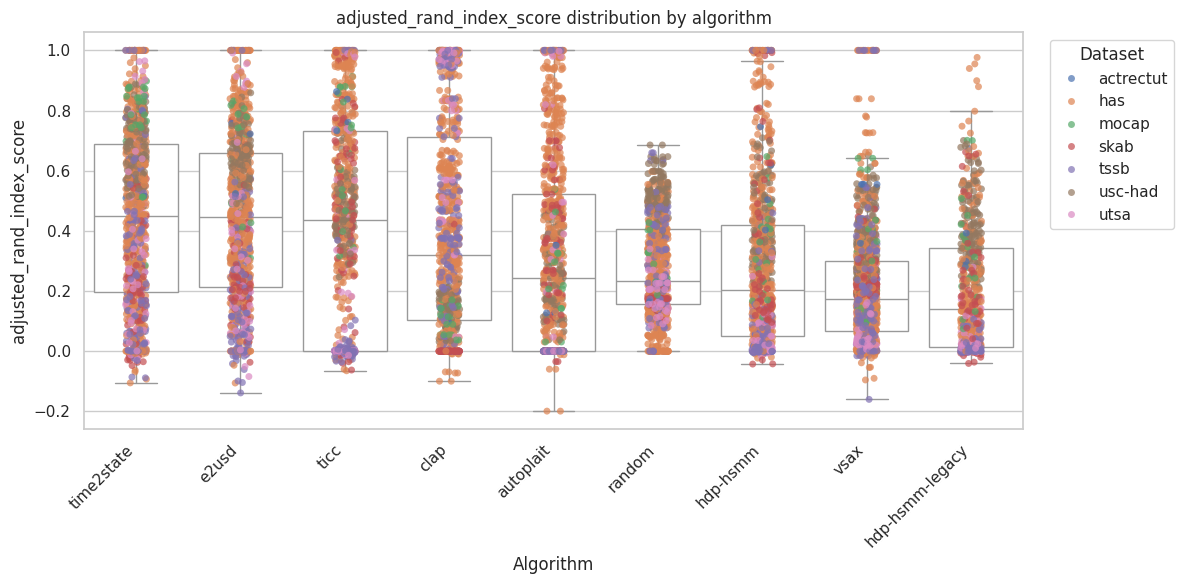

In [21]:
if runs_df.empty:
    print("No runs available to plot.")
else:
    plot_metric_boxplot(runs_df, metric_key="adjusted_rand_index_score")

/tmp/ipykernel_22744/149688578.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)


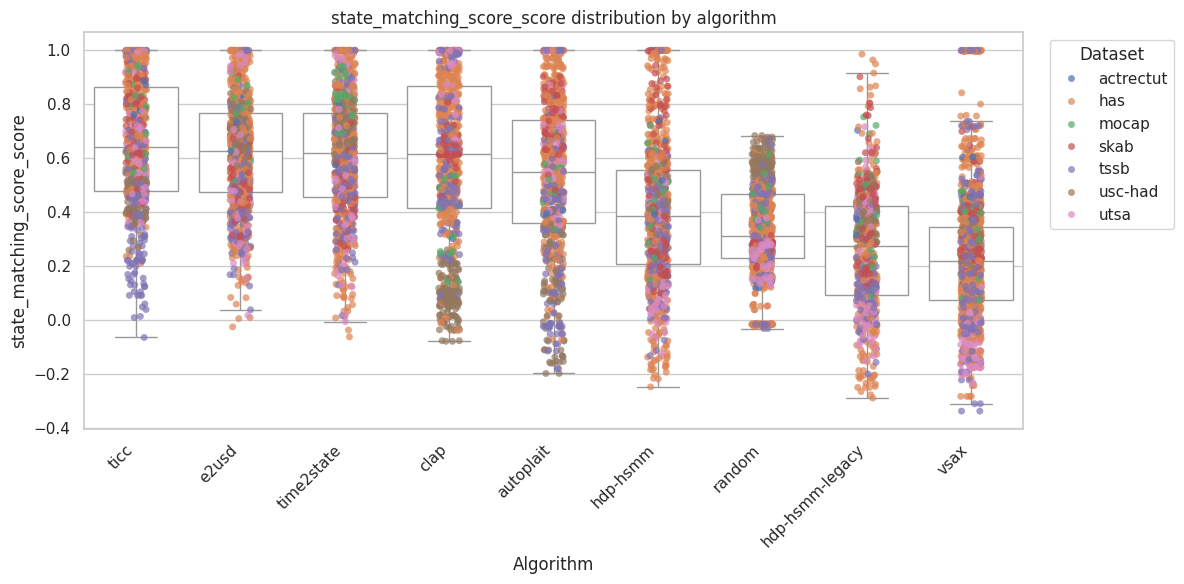

In [25]:
if runs_df.empty:
    print("No runs available to plot.")
else:
    plot_metric_boxplot(runs_df, metric_key="state_matching_score_score")

/tmp/ipykernel_7651/149688578.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df["dataset"].fillna("Unknown dataset", inplace=True)


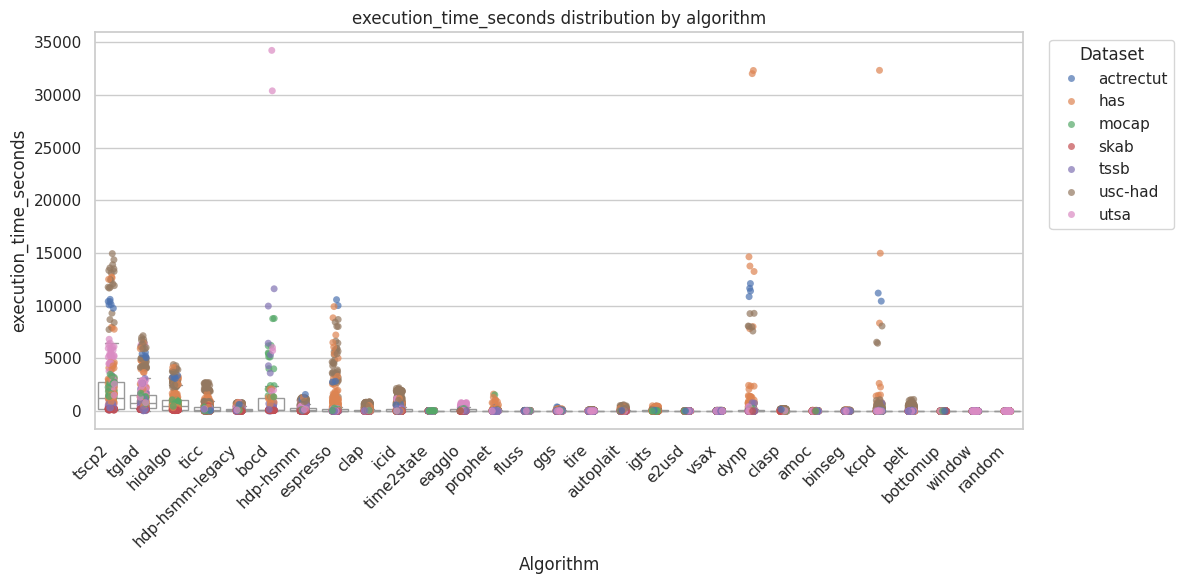

In [17]:
if runs_df.empty:
    print("No runs available to plot.")
else:
    plot_metric_boxplot(runs_df, metric_key="execution_time_seconds")